## Installing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

## Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datafile = '/content/drive/MyDrive/Datasets/abcnews-date-text.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head()

FileNotFoundError: ignored

## Preprocessing

In [ ]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

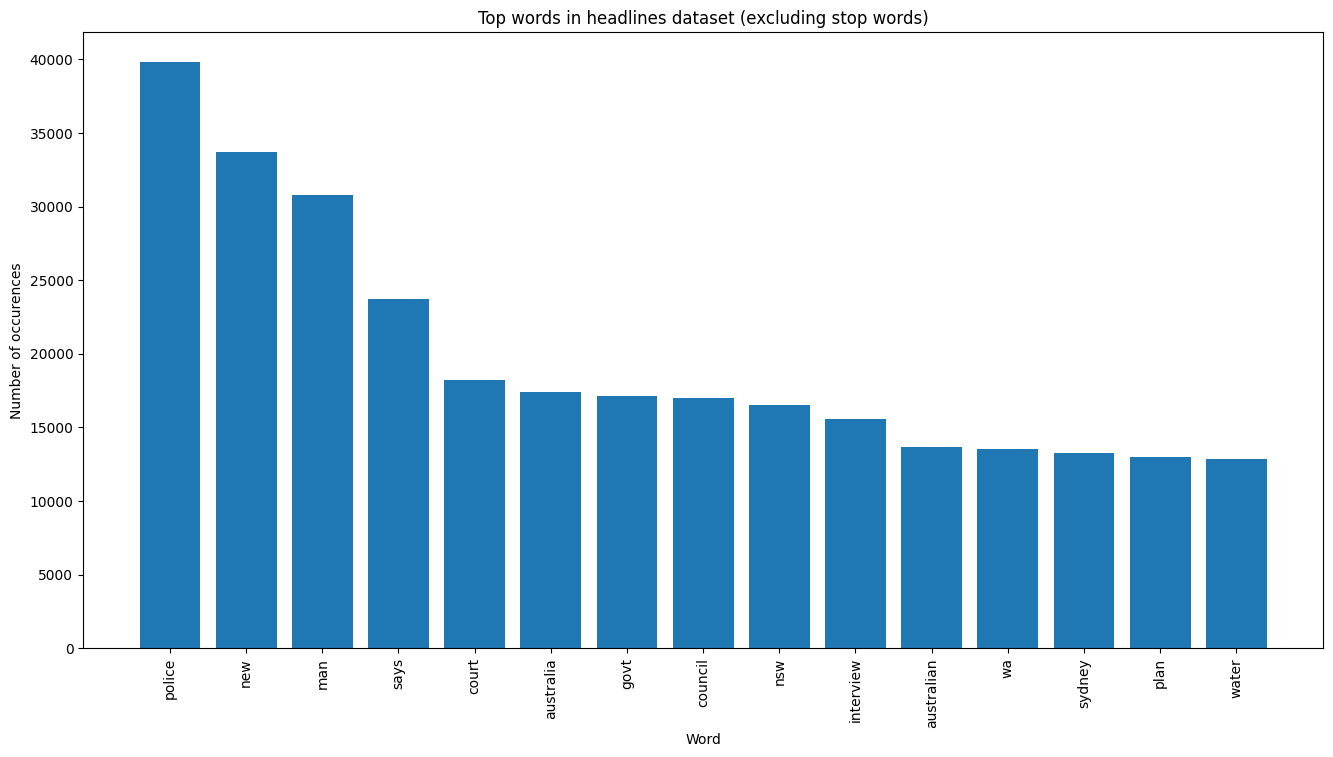

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer,
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [ ]:
text_tokens = [[text for text in tagged_headlines] for tagged_headline in tagged_headlines]

In [ ]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = []
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1

print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  8166553
Mean number of words per headline:  6.563782366595294


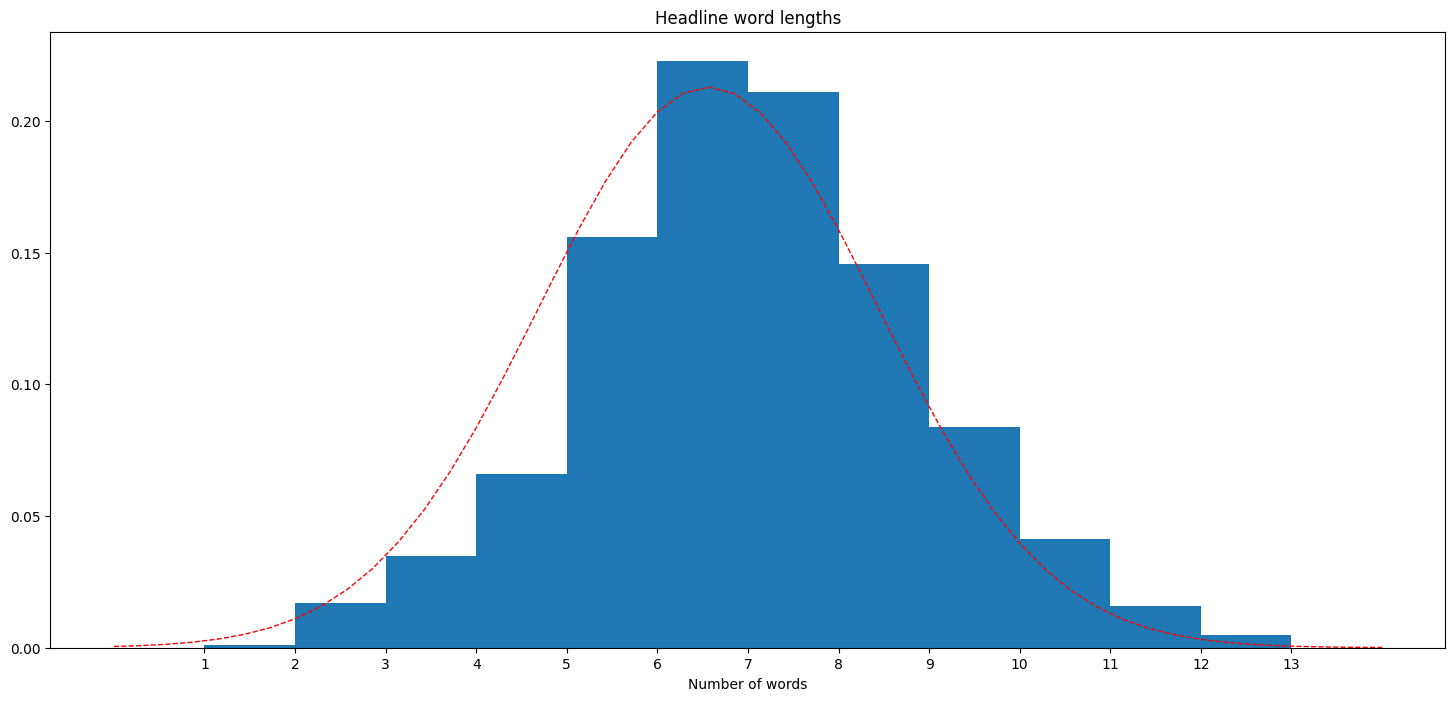

In [ ]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

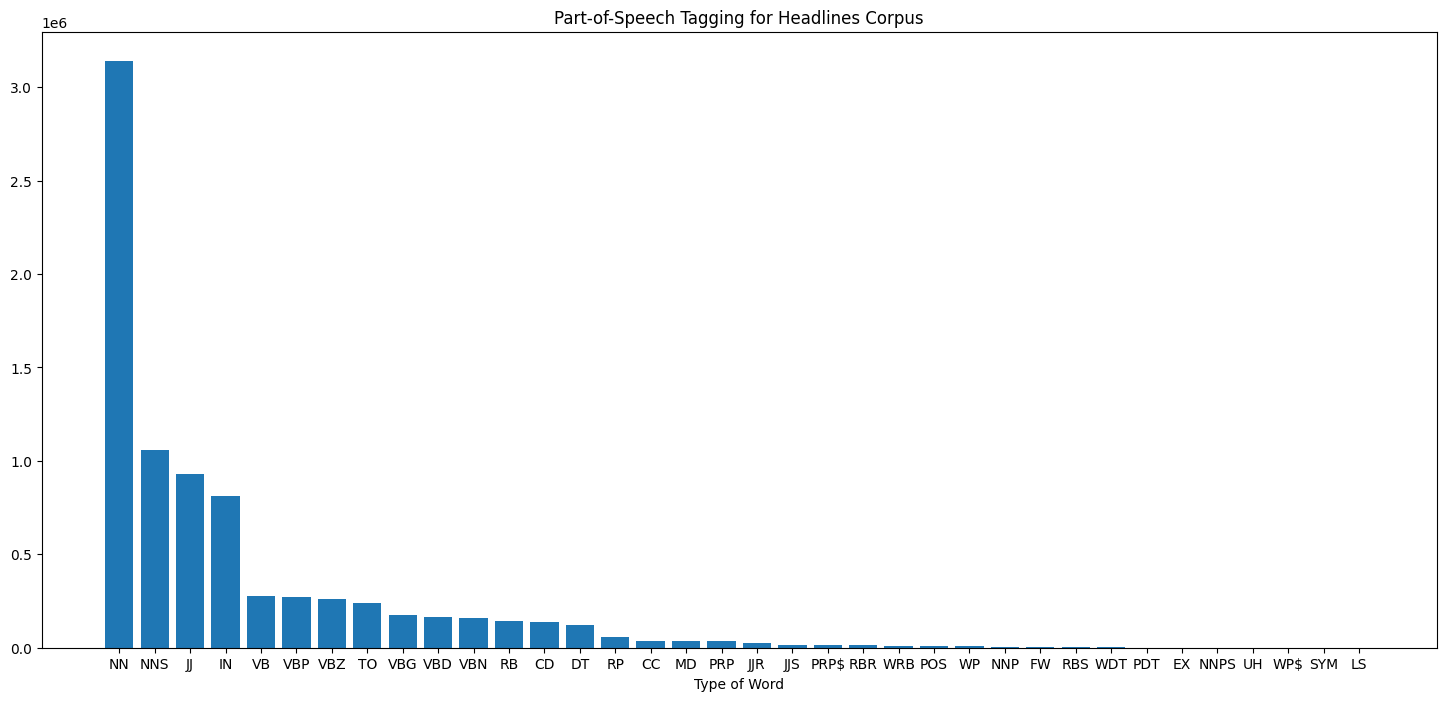

In [ ]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

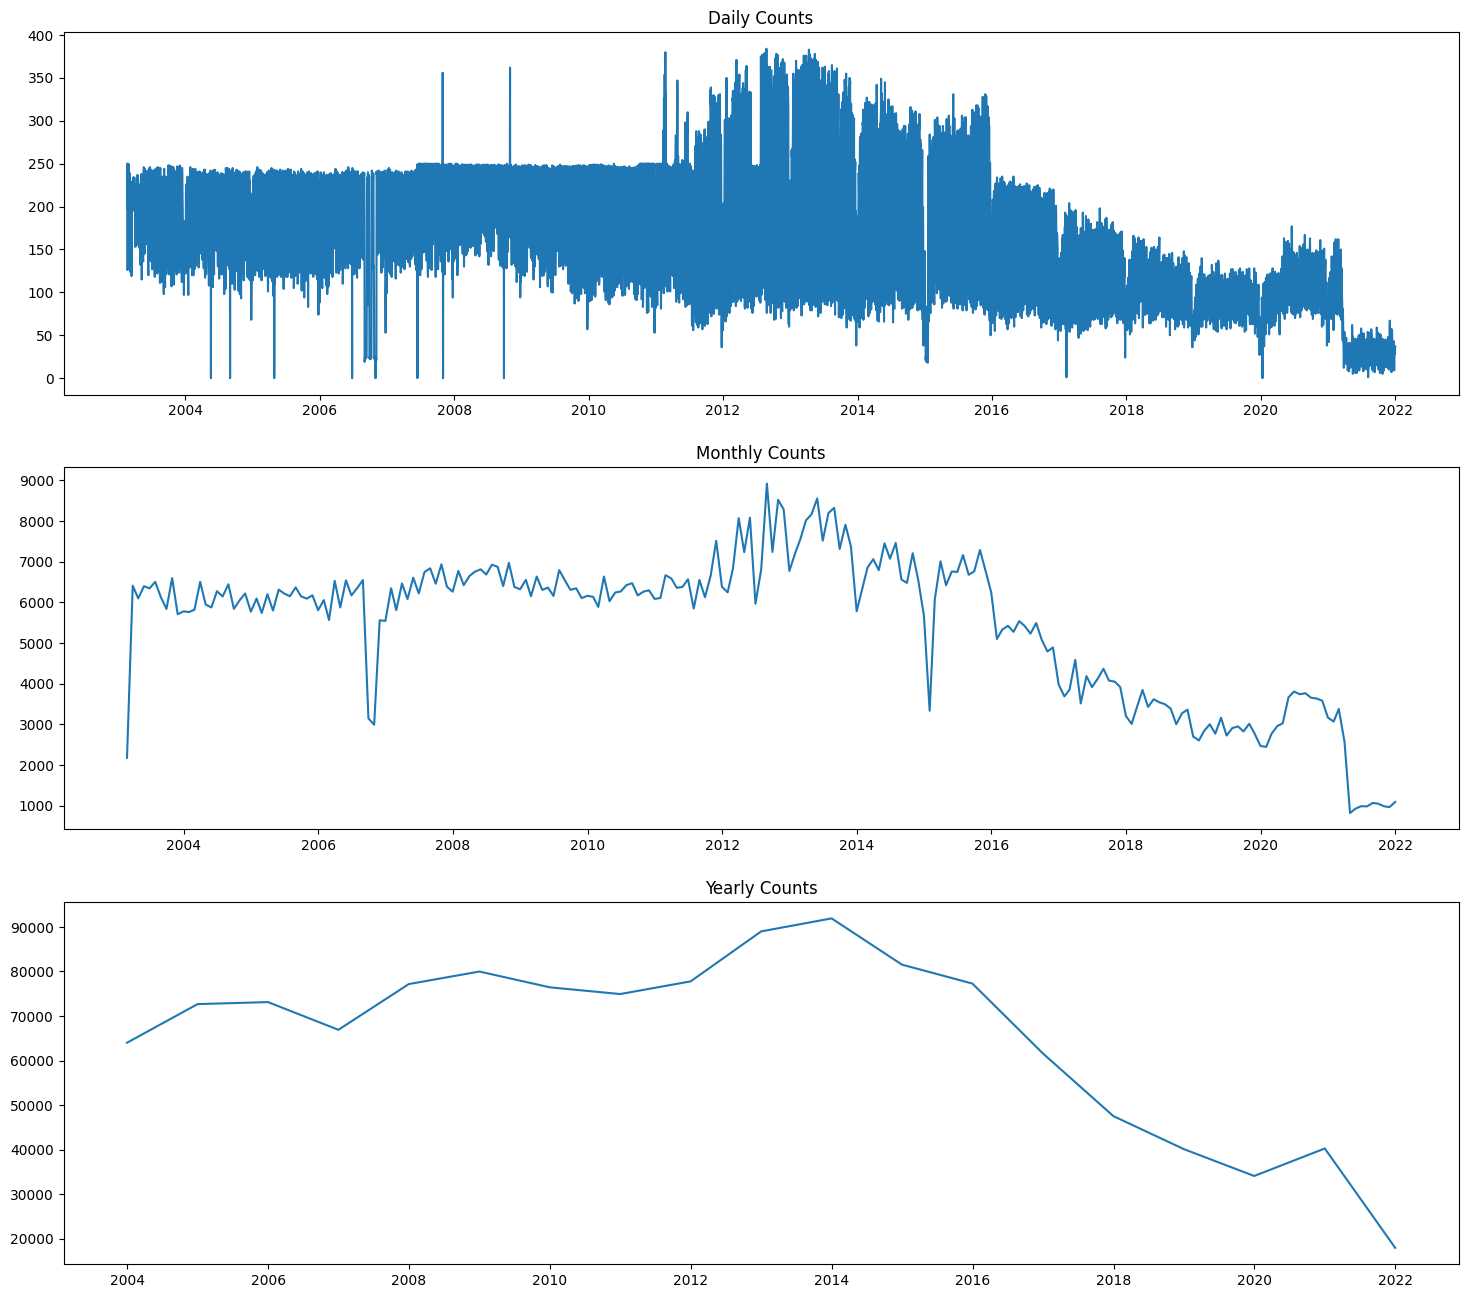

In [ ]:
monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: leaders of womens group plan parliament march to
Headline after vectorization: 
  (0, 8434)	1
  (0, 6467)	1
  (0, 12467)	1
  (0, 5001)	1
  (0, 8151)	1
  (0, 6923)	1


## Applying LSA Model

In [ ]:
n_topics = 8

In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))
    return top_words

In [ ]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  police death sydney missing murder search adelaide woman charges probe
Topic 2:  man charged guilty sex jailed child murder pleads assault death
Topic 3:  new year help indigenous deal chief home tasmanian australian laws
Topic 4:  says health wa minister election sa government workers power interview
Topic 5:  govt nsw water plan qld rural urged national calls act
Topic 6:  australia interview day cup south world coronavirus abc test covid
Topic 7:  crash car hospital killed dies report fatal plane driver road
Topic 8:  council court australian wins face residents case concerns health fight


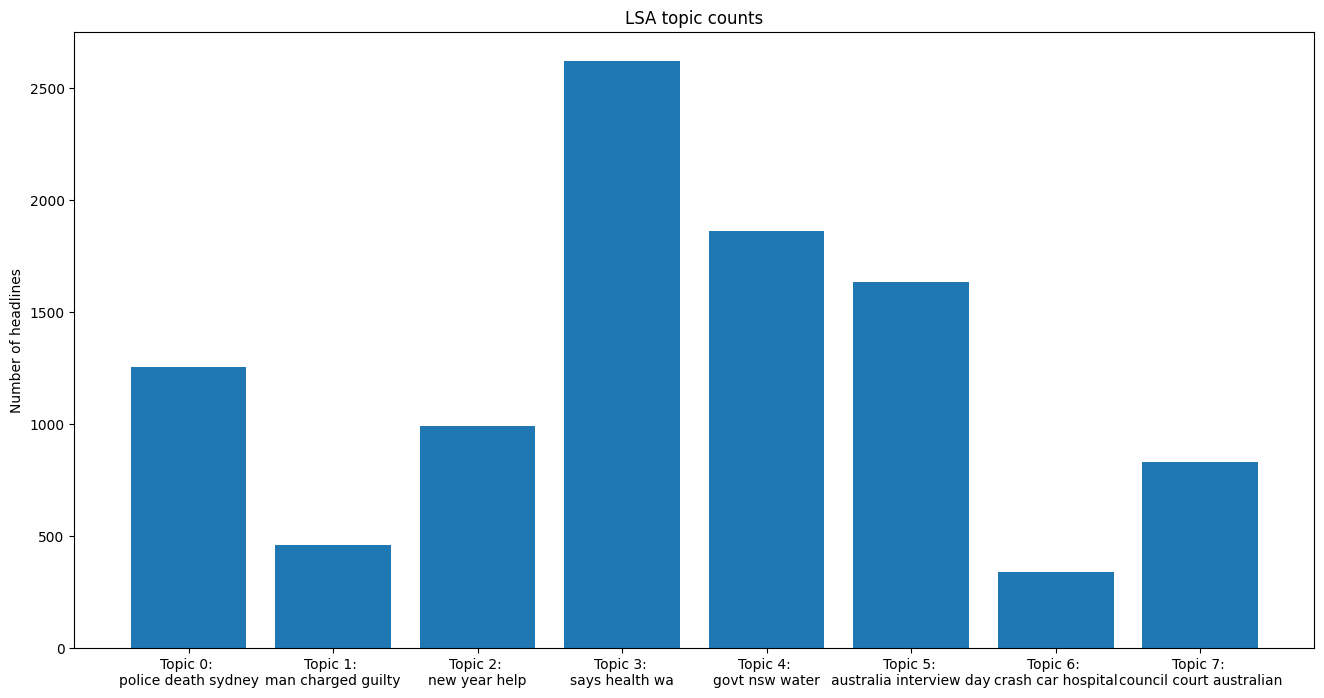

In [ ]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

## tsne with LSA

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.018s...
[t-SNE] Computed neighbors for 10000 samples in 1.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.002297
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.402679
[t-SNE] KL divergence after 2000 iterations: 1.256748


In [ ]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])

        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1],
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [ ]:
coherence_model_lsa = CoherenceModel(model=lsa_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('\nCoherence Score: ', coherence_lsa)


Coherence of LSA:  0.3864806552606242


## Applying LDA Model


In [ ]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online',
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  govt day north sydney market nt labor election final open
Topic 2:  hospital crash abc port trump budget calls deal trial indigenous
Topic 3:  cup world plan coast gold centre dies price council group
Topic 4:  interview says win iraq minister claims public australian rain change
Topic 5:  rural national home school missing farmers set funding news return
Topic 6:  police man new crash charged car child murder accused guilty
Topic 7:  australia health south qld water court new wa coronavirus death
Topic 8:  council nsw urged workers government tax fears weather union action


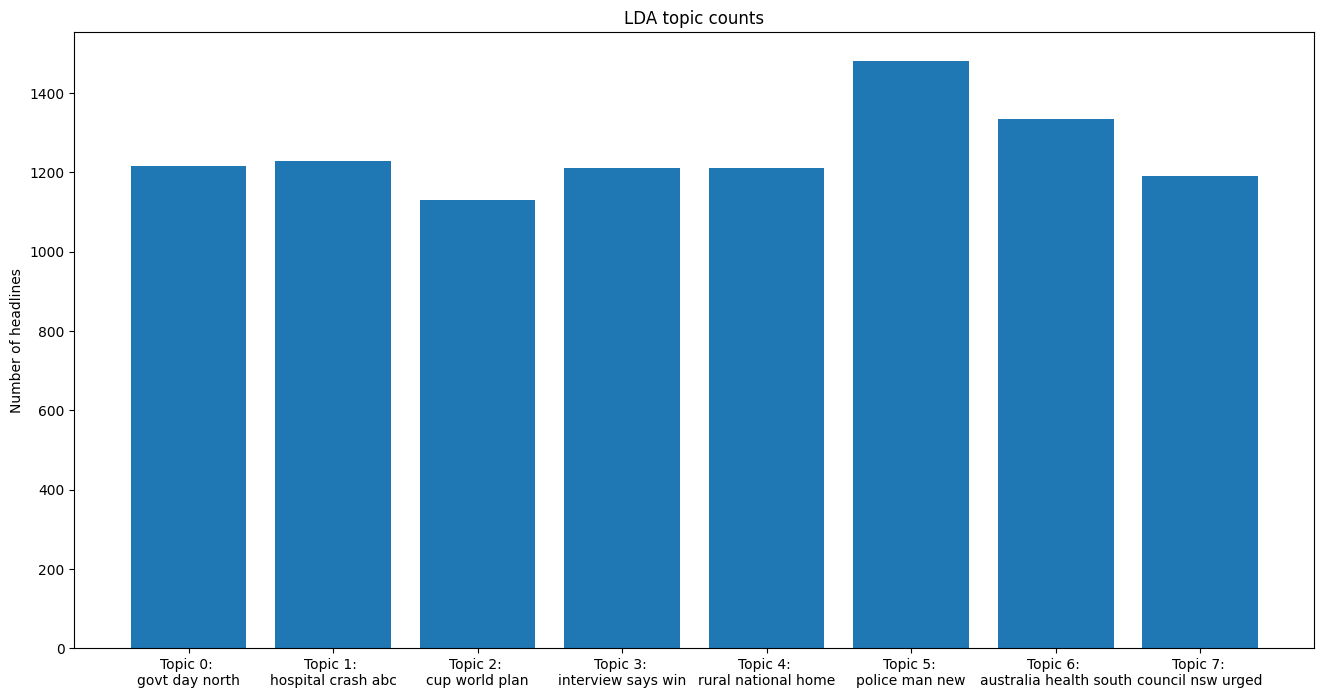

In [ ]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

## tsne with LDA Model

In [ ]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.026s...
[t-SNE] Computed neighbors for 10000 samples in 1.377s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.320862
[t-SNE] KL divergence after 2000 iterations: 1.248359


In [ ]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1],
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence of LDA:  0.6008265482109711


## Applying NMF Model


In [ ]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=8, random_state=0)

In [ ]:
nmf_topic_matrix = nmf.fit_transform(small_document_term_matrix)

In [ ]:
nmf_keys = get_keys(nmf_topic_matrix)
nmf_categories, nmf_counts = keys_to_counts(nmf_keys)

In [ ]:
top_n_words_nmf = get_top_n_words(10, nmf_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_nmf)):
    print("Topic {}: ".format(i+1), top_n_words_nmf[i])

Topic 1:  police search missing investigate appeal probe hunt officer station car
Topic 2:  man court death sydney charged murder sex child guilty jailed
Topic 3:  new year help chief indigenous gives zealand study old home
Topic 4:  says health minister iraq workers end mp attack election mental
Topic 5:  govt nsw wa qld rural national coast north calls urged
Topic 6:  australia interview australian day win cup south world wins coronavirus
Topic 7:  crash car dies hospital killed fatal report road driver injured
Topic 8:  council plan water deal residents fears centre concerns change price


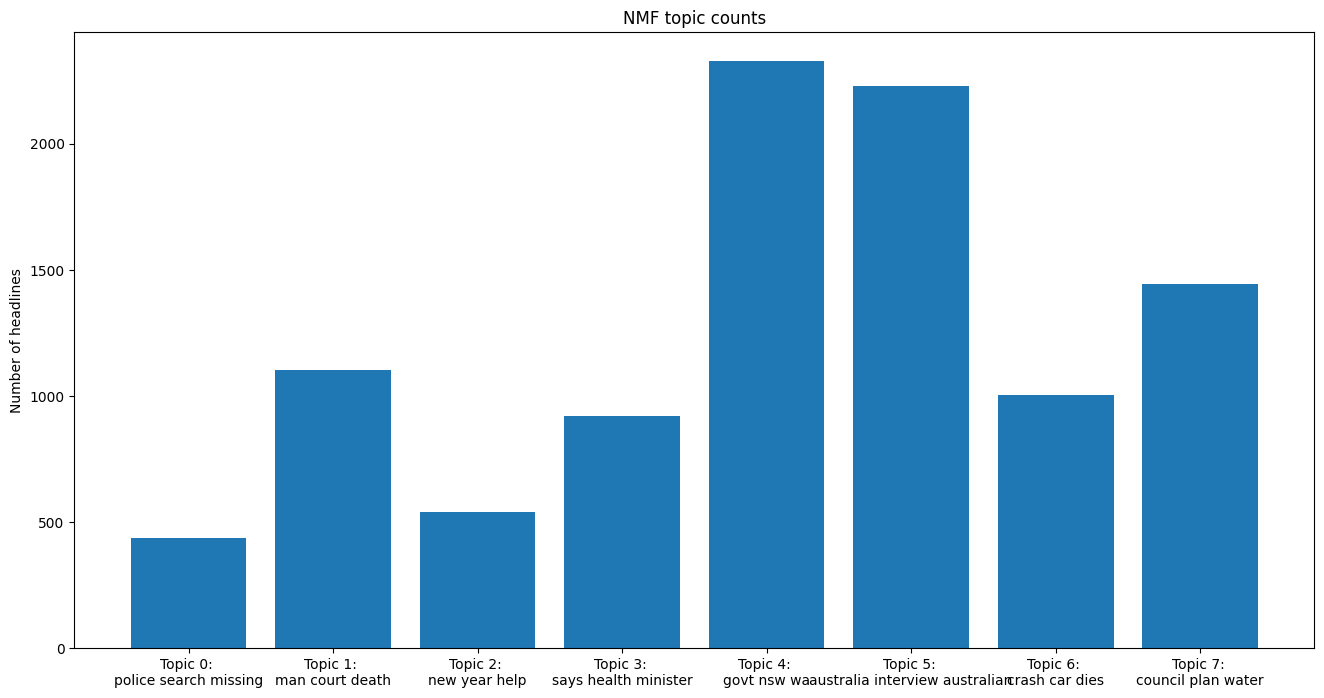

In [ ]:
top_3_words = get_top_n_words(3, nmf_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in nmf_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(nmf_categories, nmf_counts);
ax.set_xticks(nmf_categories);
ax.set_xticklabels(labels);
ax.set_title('NMF topic counts');
ax.set_ylabel('Number of headlines');

## tsne with NMF Model

In [ ]:
tsne_nmf_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_nmf_vectors = tsne_nmf_model.fit_transform(nmf_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.023s...
[t-SNE] Computed neighbors for 10000 samples in 1.617s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.439590
[t-SNE] KL divergence after 2000 iterations: 1.199524


In [ ]:
top_3_words_nmf = get_top_n_words(3, nmf_keys, small_document_term_matrix, small_count_vectorizer)
nmf_mean_topic_vectors = get_mean_topic_vectors(nmf_keys, tsne_nmf_vectors)

plot = figure(title="t-SNE Clustering of {} NMF Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_nmf_vectors[:,0], y=tsne_nmf_vectors[:,1], color=colormap[nmf_keys])

for t in range(n_topics):
    label = Label(x=nmf_mean_topic_vectors[t][0], y=nmf_mean_topic_vectors[t][1],
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [ ]:
coherence_model_nmf = CoherenceModel(model=nmf_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score: ', coherence_nmf)


Coherence of NMF:  0.4164806552606242


## Applying LDA Model on bigger dataset

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
big_sample_size = 100000

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

In [ ]:
stemmer = SnowballStemmer("english")

In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
print(big_text_sample[4310])

maroons name origin iii squad


In [ ]:
doc_sample = big_text_sample[4310]
print('original document: ')
wordso = []
for word in doc_sample.split(' '):
    wordso.append(word)
print(wordso)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['maroons', 'name', 'origin', 'iii', 'squad']


 tokenized and lemmatized document: 
['maroon', 'origin', 'squad']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd
df = pd.DataFrame(big_text_sample, columns = ['headlines'])

In [ ]:
df.head()

,headlines
0,dave oliver am
1,how did coronavirus start where did bats get c...
2,norman supports future of oneasia tour
3,national rural news
4,council moves closer to wave maker installation


In [ ]:
processed_docs = df['headlines'].map(preprocess)
processed_docs[:10]

0                                         [dave, oliv]
1                     [coronavirus, start, bat, covid]
2              [norman, support, futur, oneasia, tour]
3                                [nation, rural, news]
4         [council, move, closer, wave, maker, instal]
5        [poor, record, leav, billion, unclaim, super]
6                                              [alert]
7             [flotilla, take, anti, nuclear, protest]
8    [virgin, wont, follow, qanta, fuel, surcharg, ...
9                   [fund, review, get, back, develop]
Name: headlines, dtype: object

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 dave
1 oliv
2 bat
3 coronavirus
4 covid
5 start
6 futur
7 norman
8 oneasia
9 support
10 tour


In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(1680, 1), (2612, 1), (2825, 1)]

In [ ]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0],
                                               dictionary[bow_doc_4310[i][0]],
bow_doc_4310[i][1]))

Word 1680 ("origin") appears 1 time.
Word 2612 ("squad") appears 1 time.
Word 2825 ("maroon") appears 1 time.


In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break


[(0, 1.0)]


In [ ]:
big_lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [ ]:
for idx, topic in big_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.017*"flood" + 0.012*"warn" + 0.010*"clear" + 0.010*"black" + 0.009*"cut" + 0.009*"threat" + 0.009*"join" + 0.009*"free" + 0.008*"trade" + 0.008*"australia"
Topic: 1 
Words: 0.014*"park" + 0.013*"fall" + 0.013*"releas" + 0.012*"rise" + 0.011*"say" + 0.010*"children" + 0.009*"hospit" + 0.008*"defend" + 0.008*"report" + 0.008*"appeal"
Topic: 2 
Words: 0.041*"polic" + 0.038*"charg" + 0.018*"death" + 0.016*"test" + 0.016*"drug" + 0.015*"face" + 0.015*"court" + 0.014*"murder" + 0.014*"arrest" + 0.013*"case"
Topic: 3 
Words: 0.016*"farmer" + 0.016*"market" + 0.015*"australian" + 0.015*"final" + 0.015*"busi" + 0.014*"coast" + 0.014*"rural" + 0.012*"gold" + 0.011*"open" + 0.011*"news"
Topic: 4 
Words: 0.018*"road" + 0.016*"health" + 0.015*"centr" + 0.013*"rule" + 0.013*"hold" + 0.011*"train" + 0.010*"studi" + 0.010*"station" + 0.010*"rat" + 0.008*"council"
Topic: 5 
Words: 0.019*"court" + 0.019*"elect" + 0.019*"jail" + 0.016*"dead" + 0.015*"green" + 0.012*"guilti" + 0.011*"la

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.008*"polic" + 0.008*"shoot" + 0.008*"miss" + 0.008*"coast" + 0.008*"search" + 0.008*"dead" + 0.006*"gold" + 0.004*"investig" + 0.004*"continu" + 0.004*"open"
Topic: 1 Word: 0.009*"countri" + 0.008*"crash" + 0.008*"hour" + 0.006*"death" + 0.006*"babi" + 0.006*"child" + 0.005*"plane" + 0.005*"die" + 0.004*"polic" + 0.004*"road"
Topic: 2 Word: 0.007*"charg" + 0.007*"assault" + 0.005*"report" + 0.005*"dairi" + 0.005*"bushfir" + 0.005*"polic" + 0.005*"impact" + 0.004*"hous" + 0.004*"warn" + 0.004*"bodi"
Topic: 3 Word: 0.012*"rural" + 0.010*"news" + 0.006*"nation" + 0.006*"busi" + 0.006*"australia" + 0.005*"north" + 0.005*"farm" + 0.005*"south" + 0.004*"final" + 0.004*"point"
Topic: 4 Word: 0.007*"polic" + 0.006*"market" + 0.006*"closer" + 0.006*"share" + 0.006*"council" + 0.005*"fatal" + 0.005*"health" + 0.005*"drought" + 0.005*"water" + 0.004*"seek"
Topic: 5 Word: 0.007*"kill" + 0.006*"truck" + 0.005*"accid" + 0.005*"strike" + 0.005*"media" + 0.005*"asylum" + 0.004*"minist

In [ ]:
for index, score in sorted(big_lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, big_lda_model.print_topic(index, 10)))


Score: 0.5254987478256226	 
Topic: 0.041*"polic" + 0.038*"charg" + 0.018*"death" + 0.016*"test" + 0.016*"drug" + 0.015*"face" + 0.015*"court" + 0.014*"murder" + 0.014*"arrest" + 0.013*"case"

Score: 0.2744692265987396	 
Topic: 0.029*"kill" + 0.028*"crash" + 0.021*"fear" + 0.018*"water" + 0.013*"want" + 0.012*"die" + 0.011*"chang" + 0.010*"lead" + 0.010*"driver" + 0.010*"coronavirus"

Score: 0.025004824623465538	 
Topic: 0.038*"interview" + 0.018*"time" + 0.017*"break" + 0.016*"budget" + 0.015*"bushfir" + 0.014*"countri" + 0.013*"trump" + 0.012*"start" + 0.010*"hill" + 0.010*"extend"

Score: 0.025004535913467407	 
Topic: 0.019*"court" + 0.019*"elect" + 0.019*"jail" + 0.016*"dead" + 0.015*"green" + 0.012*"guilti" + 0.011*"labor" + 0.011*"iraq" + 0.011*"prison" + 0.010*"accus"

Score: 0.02500416897237301	 
Topic: 0.018*"road" + 0.016*"health" + 0.015*"centr" + 0.013*"rule" + 0.013*"hold" + 0.011*"train" + 0.010*"studi" + 0.010*"station" + 0.010*"rat" + 0.008*"council"

Score: 0.025003904

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.3315293490886688	 
Topic: 0.007*"charg" + 0.007*"assault" + 0.005*"report" + 0.005*"dairi" + 0.005*"bushfir" + 0.005*"polic" + 0.005*"impact" + 0.004*"hous" + 0.004*"warn" + 0.004*"bodi"

Score: 0.30832332372665405	 
Topic: 0.008*"polic" + 0.008*"shoot" + 0.008*"miss" + 0.008*"coast" + 0.008*"search" + 0.008*"dead" + 0.006*"gold" + 0.004*"investig" + 0.004*"continu" + 0.004*"open"

Score: 0.18508151173591614	 
Topic: 0.009*"weather" + 0.007*"hill" + 0.007*"drum" + 0.006*"guilti" + 0.005*"friday" + 0.005*"flood" + 0.005*"plead" + 0.005*"violenc" + 0.005*"year" + 0.005*"tuesday"

Score: 0.025012321770191193	 
Topic: 0.030*"interview" + 0.007*"sport" + 0.007*"drink" + 0.006*"trump" + 0.005*"polic" + 0.005*"drive" + 0.005*"extend" + 0.004*"donald" + 0.004*"jail" + 0.004*"john"

Score: 0.025010569021105766	 
Topic: 0.007*"kill" + 0.006*"truck" + 0.005*"accid" + 0.005*"strike" + 0.005*"media" + 0.005*"asylum" + 0.004*"minist" + 0.004*"island" + 0.004*"teacher" + 0.004*"china"

Scor

In [ ]:
big_text_sample[17]

'dogs and athletes nutrition'

In [ ]:
unseen_document = 'turkey faces snap polls as coalition talks fail'
print(unseen_document)
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(big_lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, big_lda_model.print_topic(index, 5)))

turkey faces snap polls as coalition talks fail
Score: 0.36565136909484863	 Topic: 0.019*"court" + 0.019*"elect" + 0.019*"jail" + 0.016*"dead" + 0.015*"green"
Score: 0.31935983896255493	 Topic: 0.019*"miss" + 0.018*"home" + 0.017*"polic" + 0.016*"hous" + 0.014*"school"
Score: 0.22746385633945465	 Topic: 0.038*"interview" + 0.018*"time" + 0.017*"break" + 0.016*"budget" + 0.015*"bushfir"
Score: 0.01250643189996481	 Topic: 0.041*"polic" + 0.038*"charg" + 0.018*"death" + 0.016*"test" + 0.016*"drug"
Score: 0.012504294514656067	 Topic: 0.018*"road" + 0.016*"health" + 0.015*"centr" + 0.013*"rule" + 0.013*"hold"
Score: 0.012503520585596561	 Topic: 0.028*"plan" + 0.027*"govt" + 0.022*"urg" + 0.020*"council" + 0.015*"fund"
Score: 0.012503065168857574	 Topic: 0.017*"flood" + 0.012*"warn" + 0.010*"clear" + 0.010*"black" + 0.009*"cut"
Score: 0.012502864934504032	 Topic: 0.016*"farmer" + 0.016*"market" + 0.015*"australian" + 0.015*"final" + 0.015*"busi"
Score: 0.012502556666731834	 Topic: 0.029*"kil

In [ ]:
unseen_document = 'concerns aired over bushfire submissions snub'
print(unseen_document)
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(big_lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, big_lda_model.print_topic(index, 5)))

concerns aired over bushfire submissions snub
Score: 0.4136221706867218	 Topic: 0.028*"plan" + 0.027*"govt" + 0.022*"urg" + 0.020*"council" + 0.015*"fund"
Score: 0.2829938232898712	 Topic: 0.019*"miss" + 0.018*"home" + 0.017*"polic" + 0.016*"hous" + 0.014*"school"
Score: 0.18669858574867249	 Topic: 0.038*"interview" + 0.018*"time" + 0.017*"break" + 0.016*"budget" + 0.015*"bushfir"
Score: 0.016669591888785362	 Topic: 0.017*"flood" + 0.012*"warn" + 0.010*"clear" + 0.010*"black" + 0.009*"cut"
Score: 0.016669349744915962	 Topic: 0.018*"road" + 0.016*"health" + 0.015*"centr" + 0.013*"rule" + 0.013*"hold"
Score: 0.01666933298110962	 Topic: 0.014*"park" + 0.013*"fall" + 0.013*"releas" + 0.012*"rise" + 0.011*"say"
Score: 0.01666928641498089	 Topic: 0.041*"polic" + 0.038*"charg" + 0.018*"death" + 0.016*"test" + 0.016*"drug"
Score: 0.01666928641498089	 Topic: 0.016*"farmer" + 0.016*"market" + 0.015*"australian" + 0.015*"final" + 0.015*"busi"
Score: 0.01666928641498089	 Topic: 0.019*"court" + 0.0

In [ ]:
unseen_document = 'government plans lote teacher boost'
print(unseen_document)
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(big_lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, big_lda_model.print_topic(index, 5)))

government plans lote teacher boost
Score: 0.6109494566917419	 Topic: 0.028*"plan" + 0.027*"govt" + 0.022*"urg" + 0.020*"council" + 0.015*"fund"
Score: 0.2290329486131668	 Topic: 0.017*"flood" + 0.012*"warn" + 0.010*"clear" + 0.010*"black" + 0.009*"cut"
Score: 0.020005416125059128	 Topic: 0.016*"farmer" + 0.016*"market" + 0.015*"australian" + 0.015*"final" + 0.015*"busi"
Score: 0.020002927631139755	 Topic: 0.019*"miss" + 0.018*"home" + 0.017*"polic" + 0.016*"hous" + 0.014*"school"
Score: 0.02000216580927372	 Topic: 0.014*"park" + 0.013*"fall" + 0.013*"releas" + 0.012*"rise" + 0.011*"say"
Score: 0.020002009347081184	 Topic: 0.038*"interview" + 0.018*"time" + 0.017*"break" + 0.016*"budget" + 0.015*"bushfir"
Score: 0.020001694560050964	 Topic: 0.029*"kill" + 0.028*"crash" + 0.021*"fear" + 0.018*"water" + 0.013*"want"
Score: 0.02000131458044052	 Topic: 0.019*"court" + 0.019*"elect" + 0.019*"jail" + 0.016*"dead" + 0.015*"green"
Score: 0.020001230761408806	 Topic: 0.018*"road" + 0.016*"healt

In [ ]:
unseen_document = 'review announced for mount gambier hospital'
print(unseen_document)
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(big_lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, big_lda_model.print_topic(index, 5)))

review announced for mount gambier hospital
Score: 0.8499653339385986	 Topic: 0.028*"plan" + 0.027*"govt" + 0.022*"urg" + 0.020*"council" + 0.015*"fund"
Score: 0.0166747085750103	 Topic: 0.029*"kill" + 0.028*"crash" + 0.021*"fear" + 0.018*"water" + 0.013*"want"
Score: 0.016673432663083076	 Topic: 0.014*"park" + 0.013*"fall" + 0.013*"releas" + 0.012*"rise" + 0.011*"say"
Score: 0.016670525074005127	 Topic: 0.018*"road" + 0.016*"health" + 0.015*"centr" + 0.013*"rule" + 0.013*"hold"
Score: 0.016670243814587593	 Topic: 0.019*"miss" + 0.018*"home" + 0.017*"polic" + 0.016*"hous" + 0.014*"school"
Score: 0.01667005382478237	 Topic: 0.041*"polic" + 0.038*"charg" + 0.018*"death" + 0.016*"test" + 0.016*"drug"
Score: 0.01666937954723835	 Topic: 0.038*"interview" + 0.018*"time" + 0.017*"break" + 0.016*"budget" + 0.015*"bushfir"
Score: 0.01666886918246746	 Topic: 0.019*"court" + 0.019*"elect" + 0.019*"jail" + 0.016*"dead" + 0.015*"green"
Score: 0.01666877418756485	 Topic: 0.016*"farmer" + 0.016*"mark

In [ ]:
unseen_document = 'penguins stabs ishika'
print(unseen_document)
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

penguins stabs ishika
Score: 0.373473584651947	 Topic: 0.009*"countri" + 0.008*"crash" + 0.008*"hour" + 0.006*"death" + 0.006*"babi"
Score: 0.3598032295703888	 Topic: 0.011*"court" + 0.009*"charg" + 0.009*"murder" + 0.008*"stab" + 0.007*"accus"
Score: 0.03334074094891548	 Topic: 0.007*"polic" + 0.006*"market" + 0.006*"closer" + 0.006*"share" + 0.006*"council"
Score: 0.033340565860271454	 Topic: 0.012*"rural" + 0.010*"news" + 0.006*"nation" + 0.006*"busi" + 0.006*"australia"
Score: 0.03334042802453041	 Topic: 0.007*"kill" + 0.006*"truck" + 0.005*"accid" + 0.005*"strike" + 0.005*"media"
Score: 0.03334037587046623	 Topic: 0.009*"weather" + 0.007*"hill" + 0.007*"drum" + 0.006*"guilti" + 0.005*"friday"
Score: 0.03334033861756325	 Topic: 0.030*"interview" + 0.007*"sport" + 0.007*"drink" + 0.006*"trump" + 0.005*"polic"
Score: 0.03334031626582146	 Topic: 0.006*"govt" + 0.006*"urg" + 0.005*"action" + 0.005*"servic" + 0.005*"plan"
Score: 0.033340226858854294	 Topic: 0.007*"charg" + 0.007*"assaul

In [ ]:
unseen_document = 'Voice referendum bill passes Senate after tense debate'
print(unseen_document)
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, big_lda_model.print_topic(index, 5)))

Voice referendum bill passes Senate after tense debate
Score: 0.8499252796173096	 Topic: 0.019*"court" + 0.019*"elect" + 0.019*"jail" + 0.016*"dead" + 0.015*"green"
Score: 0.016678346320986748	 Topic: 0.028*"plan" + 0.027*"govt" + 0.022*"urg" + 0.020*"council" + 0.015*"fund"
Score: 0.016675543040037155	 Topic: 0.018*"road" + 0.016*"health" + 0.015*"centr" + 0.013*"rule" + 0.013*"hold"
Score: 0.01667545549571514	 Topic: 0.017*"flood" + 0.012*"warn" + 0.010*"clear" + 0.010*"black" + 0.009*"cut"
Score: 0.01667536422610283	 Topic: 0.041*"polic" + 0.038*"charg" + 0.018*"death" + 0.016*"test" + 0.016*"drug"
Score: 0.016674960032105446	 Topic: 0.016*"farmer" + 0.016*"market" + 0.015*"australian" + 0.015*"final" + 0.015*"busi"
Score: 0.01667463593184948	 Topic: 0.014*"park" + 0.013*"fall" + 0.013*"releas" + 0.012*"rise" + 0.011*"say"
Score: 0.016674082726240158	 Topic: 0.038*"interview" + 0.018*"time" + 0.017*"break" + 0.016*"budget" + 0.015*"bushfir"
Score: 0.016673501580953598	 Topic: 0.019*